# Matrix matrix multiplication performance

In [1]:
import iarray as ia
import numpy as np
from itertools import zip_longest as izip
from time import time
import ctypes
import matplotlib.pyplot as plt
%matplotlib inline


mkl_rt = ctypes.CDLL('libmkl_rt.dylib')
mkl_set_num_threads = mkl_rt.MKL_Set_Num_Threads
nrep = 10

## Data

In [2]:
shape = [2000, 2000]

pshape = None
bshape = [2000, 2000]

pshape2 = [200, 200]
bshape2 = [200, 200]

size = int(np.prod(shape))

## Multithreading

In [5]:
max_num_threads = 2
res = []

for num_threads in range(1, max_num_threads+1):
    print(f"Num. threads: {num_threads}")
    mkl_set_num_threads(num_threads)
    cfg = ia.Config(max_num_threads=num_threads)
    ctx = ia.Context(cfg)

    # Numpy and plainbuffer
    a = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape)
    an = ia.iarray2numpy(ctx, a)

    b = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape)
    bn = ia.iarray2numpy(ctx, b)

    t0 = time()
    for _ in range(nrep):
        cn2 = np.matmul(an, bn)
    t1 = time()
    t_np = (t1 - t0) / nrep

    t0 = time()
    for i in range(nrep):
        c = ia.matmul(ctx, a, b, bshape, bshape)
    t1 = time()
    t_ia = (t1 - t0) / nrep

    # Superchunk without compression
    mkl_set_num_threads(num_threads)
    cfg = ia.Config(max_num_threads=num_threads)
    ctx = ia.Context(cfg)

    a = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape2)

    b = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape2)

    t0 = time()
    for i in range(nrep):
        c = ia.matmul(ctx, a, b, bshape2, bshape2)
    t1 = time()
    t_ia_s = (t1 - t0) / nrep
    
    # Superchunk with compression
    mkl_set_num_threads(num_threads)
    cfg = ia.Config(max_num_threads=num_threads, compression_level=5)
    ctx = ia.Context(cfg)

    a = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape2)

    b = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape2)

    t0 = time()
    for i in range(nrep):
        c = ia.matmul(ctx, a, b, bshape2, bshape2)
    t1 = time()
    t_ia_sc = (t1 - t0) / nrep

    # Append data
    
    res.append([t_np, t_ia, t_ia_s, t_ia_sc])

Num. threads: 1
Num. threads: 2


## Results

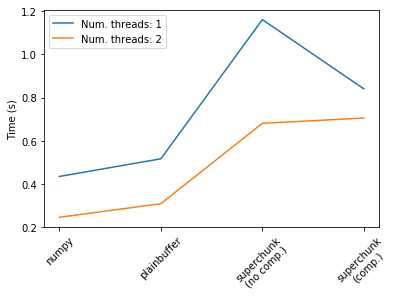

In [4]:
xticks = ("numpy", "plainbuffer", "superchunk\n(no comp.)", "superchunk\n(comp.)")
for i in range(0, max_num_threads):
    plt.plot(xticks, res[i], label=f"Num. threads: {i+1}")
plt.xticks(rotation=45)
plt.ylabel("Time (s)")
plt.legend()
plt.show()